# Prédiction de la variable cible (expenses) - Insurance Dataset

## Tâche 1 : Chargement des données

In [1]:
import pandas as pd

# Chargement des données Insurance.csv dans la variable df
df = pd.read_csv('Insurance.csv')

# Affichage des premières lignes pour vérifier le chargement
df

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


## Tâche 2 : Les différents modèles existants pour résoudre le problème

La prédiction de la variable **expenses**  est un problème de **régression** : on prédit une valeur numérique continue à partir des variables d'entrée.

### Modèles de régression classiques

| Modèle | Description |
|--------|-------------|
| **Régression Linéaire** | Modèle le plus simple 

### Modèles à arbres

| Modèle | Description |
|--------|-------------|
| **Arbre de décision (Decision Tree)** | Modèle non linéaire, facile à interpréter |
| **Random Forest** | Ensemble d'arbres ; réduit la variance et améliore la 

### Modèles pour variables mixtes (numériques + catégorielles)

| Modèle | Description |
|--------|-------------|
| **Support Vector Regression (SVR)** | Trouve un hyperplan optimal ; efficace avec des features bien préparées |
| **K-Nearest Neighbors (KNN)** | Prédit par la moyenne des K plus proches voisins |
| **Réseaux de neurones** | Modèles non linéaires complexes pour de grandes quantités de données |

### Modèle conseillé pour ce cas

Pour le jeu de données **Insurance** (variables numériques : age, bmi, children ; catégorielles : sex, smoker, region), les modèles les plus adaptés sont :
- **Random Forest** ou
- **Régression Linéaire** (après encodage des variables catégorielles) comme modèle de référence

## Tâche 3 : Préparation des données

Vérification et correction des :
- **Valeurs manquantes** (NaN, None)
- **Valeurs aberrantes** (outliers)
- **Doublons** (lignes dupliquées)

In [ ]:
# ========== 1. Vérification des valeurs manquantes ==========
print("=== Valeurs manquantes ===")
missing = df.isnull().sum()
if missing.any():
    print(missing[missing > 0])
else:
    print("Aucune valeur manquante détectée.")

=== Valeurs manquantes ===
Aucune valeur manquante détectée.


In [6]:
# Correction des valeurs manquantes (si présentes)
if df.isnull().any().any():
    # Option 1 : Supprimer les lignes avec valeurs manquantes
    df = df.dropna()
    print("Lignes avec valeurs manquantes supprimées.")
else:
    print("Aucune correction nécessaire pour les valeurs manquantes.")

Aucune correction nécessaire pour les valeurs manquantes.


In [2]:
# ========== 2. Vérification des doublons ==========
print("=== Doublons ===")
n_duplicates = df.duplicated().sum()
print(f"Nombre de lignes dupliquées : {n_duplicates}")

=== Doublons ===
Nombre de lignes dupliquées : 1


In [8]:
# Correction des doublons (si présents)
before_dedup = len(df)
df = df.drop_duplicates()
if len(df) < before_dedup:
    print(f"Doublons supprimés : {before_dedup - len(df)} lignes.")
else:
    print("Aucun doublon à supprimer.")

Doublons supprimés : 1 lignes.


In [9]:
# ========== 3. Vérification des valeurs aberrantes (outliers) ==========
print("=== Valeurs aberrantes (méthode IQR) ===")
numeric_cols = ['age', 'bmi', 'children', 'expenses']
outliers_mask = pd.Series([False] * len(df), index=df.index)

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    col_outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    n_outliers = col_outliers.sum()
    outliers_mask = outliers_mask | col_outliers
    print(f"{col}: {n_outliers} valeurs aberrantes (borne inf={lower_bound:.2f}, borne sup={upper_bound:.2f})")

print(f"\nTotal lignes contenant au moins une valeur aberrante : {outliers_mask.sum()}")

=== Valeurs aberrantes (méthode IQR) ===
age: 0 valeurs aberrantes (borne inf=-9.00, borne sup=87.00)
bmi: 9 valeurs aberrantes (borne inf=13.70, borne sup=47.30)
children: 0 valeurs aberrantes (borne inf=-3.00, borne sup=5.00)
expenses: 139 valeurs aberrantes (borne inf=-13120.73, borne sup=34524.79)

Total lignes contenant au moins une valeur aberrante : 145


In [10]:
# Correction des valeurs aberrantes (si présentes)
# On corrige uniquement les features (age, bmi, children), PAS la variable cible (expenses)
features_numeric = ['age', 'bmi', 'children']
if outliers_mask.any():
    df_corrected = df.copy()
    for col in features_numeric:  # Exclure 'expenses' - on ne modifie pas la cible
        Q1 = df_corrected[col].quantile(0.25)
        Q3 = df_corrected[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_corrected[col] = df_corrected[col].clip(lower=lower_bound, upper=upper_bound)
    df = df_corrected
    print("Valeurs aberrantes des features plafonnées (Winsorization IQR).")
else:
    print("Aucune valeur aberrante à corriger.")

Valeurs aberrantes des features plafonnées (Winsorization IQR).


In [11]:
# Résumé final après préparation des données
print("=== Résumé après préparation ===")
print(f"Nombre de lignes : {len(df)}")
print(f"Nombre de colonnes : {len(df.columns)}")
print("\nInformations du DataFrame :")
df.info()

=== Résumé après préparation ===
Nombre de lignes : 1337
Nombre de colonnes : 7

Informations du DataFrame :
<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   expenses  1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


## Tâche 4 : Séparation des variables d'entrée et de sortie

Séparation des données en :
- **X** : variables d'entrée (features) — age, sex, bmi, children, smoker, region
- **y** : variable de sortie (target) — expenses

In [ ]:
# Variable de sortie (target) : expenses
y = df['expenses']

# Variables d'entrée (features) : toutes les colonnes sauf expenses
X = df.drop(columns=['expenses'])

print("=== Variables d'entrée (X) ===")
print(f"Dimensions : {X.shape}")
print(X.head())

print("\n=== Variable de sortie (y) ===")
print(f"Dimensions : {y.shape}")
print(y.head())

=== Variables d'entrée (X) ===
Dimensions : (1337, 6)
   age     sex   bmi  children smoker     region
0   19  female  27.9         0    yes  southwest
1   18    male  33.8         1     no  southeast
2   28    male  33.0         3     no  southeast
3   33    male  22.7         0     no  northwest
4   32    male  28.9         0     no  northwest

=== Variable de sortie (y) ===
Dimensions : (1337,)
0    16884.92
1     1725.55
2     4449.46
3    21984.47
4     3866.86
Name: expenses, dtype: float64


## Tâche 5 : Division en données d'entraînement et de test

- **70%** pour l'entraînement (X_train, y_train)
- **30%** pour le test (X_test, y_test)

In [13]:
# Division : 70% entraînement, 30% test (sans sklearn - uniquement pandas)
import numpy as np

# Mélange aléatoire avec graine pour reproductibilité
np.random.seed(42)
indices = np.random.permutation(len(X))

# Calcul des tailles
train_size = int(0.70 * len(X))  # 70%
test_size = len(X) - train_size   # 30%

# Indices pour train et test
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Séparation des données
X_train = X.iloc[train_indices].reset_index(drop=True)
X_test = X.iloc[test_indices].reset_index(drop=True)
y_train = y.iloc[train_indices].reset_index(drop=True)
y_test = y.iloc[test_indices].reset_index(drop=True)

print("=== Répartition des données ===")
print(f"Données d'entraînement : {len(X_train)} observations ({len(X_train)/len(X)*100:.1f}%)")
print(f"Données de test       : {len(X_test)} observations ({len(X_test)/len(X)*100:.1f}%)")

=== Répartition des données ===
Données d'entraînement : 935 observations (69.9%)
Données de test       : 402 observations (30.1%)


## Tâche 6 : Création et entraînement des modèles

Encodage des variables catégorielles (sex, smoker, region) puis entraînement séparé des 5 modèles :
- Régression Linéaire
- Decision Tree
- Random Forest
- SVR
- KNN

In [14]:
# Préprocessing : encodage des variables catégorielles (sex, smoker, region)
# Les modèles ML nécessitent des entrées numériques
X_train_enc = pd.get_dummies(X_train, columns=['sex', 'smoker', 'region'])
X_test_enc = pd.get_dummies(X_test, columns=['sex', 'smoker', 'region'])

# Aligner les colonnes (au cas où une catégorie serait absente du test)
for col in X_train_enc.columns:
    if col not in X_test_enc.columns:
        X_test_enc[col] = 0
X_test_enc = X_test_enc[X_train_enc.columns]

print("Variables après encodage :", list(X_train_enc.columns))

Variables après encodage : ['age', 'bmi', 'children', 'sex_female', 'sex_male', 'smoker_no', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']


In [15]:
# ========== 1. Régression Linéaire ==========
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_train_enc, y_train)

print("Régression Linéaire - Modèle entraîné.")

Régression Linéaire - Modèle entraîné.


In [16]:
# ========== 2. Decision Tree (Arbre de décision) ==========
from sklearn.tree import DecisionTreeRegressor

model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train_enc, y_train)

print("Decision Tree - Modèle entraîné.")

Decision Tree - Modèle entraîné.


In [17]:
# ========== 3. Random Forest ==========
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_enc, y_train)

print("Random Forest - Modèle entraîné.")

Random Forest - Modèle entraîné.


In [21]:
# ========== 4. SVR (Support Vector Regression) ==========
# Le SVR est sensible à l'échelle des features -> normalisation requise
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

scaler_svr = StandardScaler()
X_train_scaled = scaler_svr.fit_transform(X_train_enc)
X_test_scaled_svr = scaler_svr.transform(X_test_enc)

model_svr = SVR(kernel='rbf')
model_svr.fit(X_train_scaled, y_train)

print("SVR - Modèle entraîné.")

SVR - Modèle entraîné.


In [22]:
# ========== 5. KNN (K-Nearest Neighbors) ==========
# KNN est sensible à l'échelle -> normalisation requise
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

scaler_knn = StandardScaler()
X_train_scaled_knn = scaler_knn.fit_transform(X_train_enc)
X_test_scaled_knn = scaler_knn.transform(X_test_enc)

model_knn = KNeighborsRegressor(n_neighbors=5)
model_knn.fit(X_train_scaled_knn, y_train)

print("KNN - Modèle entraîné.")

KNN - Modèle entraîné.


## Tâche 7 : Évaluation des modèles sur les données de test

Évaluation de chaque modèle avec :
- **MSE** (Mean Squared Error) : plus c'est bas, mieux c'est
- **R² (R2 Score)** : entre 0 et 1, plus c'est proche de 1, mieux c'est

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

# Prédictions sur les données de TEST pour chaque modèle
y_pred_lr = model_lr.predict(X_test_enc)
y_pred_dt = model_dt.predict(X_test_enc)
y_pred_rf = model_rf.predict(X_test_enc)
y_pred_svr = model_svr.predict(X_test_scaled_svr)
y_pred_knn = model_knn.predict(X_test_scaled_knn)

# Calcul MSE et R² pour chaque modèle
results = []
for name, y_pred in [('Régression Linéaire', y_pred_lr), ('Decision Tree', y_pred_dt), 
                     ('Random Forest', y_pred_rf), ('SVR', y_pred_svr), ('KNN', y_pred_knn)]:
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({'Modèle': name, 'MSE': mse, 'R²': r2})
    print(f"{name}: MSE = {mse:,.2f} | R² = {r2:.4f}")

Régression Linéaire: MSE = 36,683,833.80 | R² = 0.7309
Decision Tree: MSE = 45,933,790.54 | R² = 0.6630
Random Forest: MSE = 23,592,032.67 | R² = 0.8269
SVR: MSE = 147,417,879.93 | R² = -0.0815
KNN: MSE = 29,544,681.91 | R² = 0.7833


In [24]:
# Résumé en tableau
import pandas as pd
df_results = pd.DataFrame(results)
df_results

,Modèle,MSE,R²
0,Régression Linéaire,3.668383e+07,0.730888
1,Decision Tree,4.593379e+07,0.663031
2,Random Forest,2.359203e+07,0.826929
3,SVR,1.474179e+08,-0.081455
4,KNN,2.954468e+07,0.783261


## Tâche 8 : Étude comparative des modèles

Comparaison des 5 modèles sur la base des métriques MSE et R² Score.

In [25]:
# Tableau comparatif
print("=== Tableau comparatif (trié par R² décroissant) ===\n")
df_comparison = df_results.sort_values('R²', ascending=False).reset_index(drop=True)
df_comparison

=== Tableau comparatif (trié par R² décroissant) ===



,Modèle,MSE,R²
0,Random Forest,2.359203e+07,0.826929
1,KNN,2.954468e+07,0.783261
2,Régression Linéaire,3.668383e+07,0.730888
3,Decision Tree,4.593379e+07,0.663031
4,SVR,1.474179e+08,-0.081455


In [ ]:
# Analyse et conclusion
print("=== Analyse comparative ===\n")
best_r2 = df_results.loc[df_results['R²'].idxmax()]
best_mse = df_results.loc[df_results['MSE'].idxmin()]

print(f"• Meilleur modèle (R² max) : {best_r2['Modèle']} (R² = {best_r2['R²']:.4f})")
print(f"• Meilleur modèle (MSE min) : {best_mse['Modèle']} (MSE = {best_mse['MSE']:,.0f})")
print(f"\n• Classement par performance (R²) :")
for i, row in df_comparison.iterrows():
    print(f"  {i+1}. {row['Modèle']} — R² = {row['R²']:.4f} — MSE = {row['MSE']:,.0f}")

=== Analyse comparative ===

• Meilleur modèle (R² max) : Random Forest (R² = 0.8269)
• Meilleur modèle (MSE min) : Random Forest (MSE = 23,592,033)

• Classement par performance (R²) :
  1. Random Forest — R² = 0.8269 — MSE = 23,592,033
  2. KNN — R² = 0.7833 — MSE = 29,544,682
  3. Régression Linéaire — R² = 0.7309 — MSE = 36,683,834
  4. Decision Tree — R² = 0.6630 — MSE = 45,933,791
  5. SVR — R² = -0.0815 — MSE = 147,417,880


### Interprétation

- **MSE** : erreur quadratique moyenne ; un MSE faible indique des prédictions proches des valeurs réelles.
- **R²** : proportion de la variance expliquée par le modèle ; R² proche de 1 = bon ajustement, R² négatif = modèle moins bon qu'une prédiction par la moyenne.

**Résultats typiques** : Random Forest et KNN performent souvent bien sur ce jeu de données ; la Régression Linéaire reste interprétable avec une performance correcte ; SVR peut nécessiter un réglage des hyperparamètres pour améliorer ses résultats.

## Tâche 9 : Sauvegarde du meilleur modèle

Sauvegarde du modèle ayant le meilleur R² (performance sur les données de test).

## Vérification avant déploiement : Random Forest

- **Surajustement (overfitting)** : comparer les métriques Train vs Test — si Train ≫ Test, le modèle mémorise les données.
- **Oversampling** : utilisé en **classification** pour les classes déséquilibrées. **Non applicable ici** (régression).

In [ ]:
# 1. Vérification du surajustement (Train vs Test) - Random Forest
y_pred_train_rf = model_rf.predict(X_train_enc)
y_pred_test_rf = model_rf.predict(X_test_enc)

mse_train = mean_squared_error(y_train, y_pred_train_rf)
mse_test = mean_squared_error(y_test, y_pred_test_rf)
r2_train = r2_score(y_train, y_pred_train_rf)
r2_test = r2_score(y_test, y_pred_test_rf)

print("=== Random Forest : Train vs Test ===\n")
print(f"            Train      Test")
print(f"MSE :       {mse_train:>12,.0f}   {mse_test:>12,.0f}")
print(f"R²  :       {r2_train:>12.4f}   {r2_test:>12.4f}")
print(f"\nÉcart R² (Train - Test) : {r2_train - r2_test:.4f}")

if r2_train - r2_test > 0.15:
    print(" Risque de surajustement : écart Train-Test notable.")
else:
    print("✓ Pas de surajustement marqué : le modèle généralise correctement.")

=== Random Forest : Train vs Test ===

            Train      Test
MSE :          3,460,560     23,592,033
R²  :             0.9771         0.8269

Écart R² (Train - Test) : 0.1501
⚠️ Risque de surajustement : écart Train-Test notable.


### Option : Random Forest régularisé (réduire le surajustement)

Réentraînement avec `max_depth`, `min_samples_leaf` pour limiter la profondeur des arbres et réduire l'écart Train-Test.

In [33]:
# Random Forest régularisé (réduit le surajustement)
model_rf_reg = RandomForestRegressor(
    n_estimators=100,
    max_depth=12,           # Limite la profondeur des arbres
    min_samples_leaf=5,     # Minimum d'observations par feuille
    min_samples_split=10,   # Minimum pour créer une split
    random_state=42
)
model_rf_reg.fit(X_train_enc, y_train)

# Comparaison Train vs Test
r2_train_reg = r2_score(y_train, model_rf_reg.predict(X_train_enc))
r2_test_reg = r2_score(y_test, model_rf_reg.predict(X_test_enc))
ecart_reg = r2_train_reg - r2_test_reg

print("=== Random Forest régularisé : Train vs Test ===\n")
print(f"            Train      Test      Écart R²")
print(f"RF original: 0.9771    0.8269    0.1501")
print(f"RF régul.  : {r2_train_reg:.4f}    {r2_test_reg:.4f}    {ecart_reg:.4f}")
if ecart_reg <= 0.15:
    print("\n✓ Écart réduit : modèle plus généralisant. Recommandé pour déploiement.")
else:
    print("\n Écart encore notable. On peut garder le RF original (R² test = 0.83).")

=== Random Forest régularisé : Train vs Test ===

            Train      Test      Écart R²
RF original: 0.9771    0.8269    0.1501
RF régul.  : 0.9098    0.8528    0.0570

✓ Écart réduit : modèle plus généralisant. Recommandé pour déploiement.


In [34]:
# Si le RF régularisé a un écart < 0.15 : sauvegarder ce modèle pour le déploiement
if ecart_reg <= 0.15 and r2_test_reg >= 0.75:
    joblib.dump(model_rf_reg, 'best_model.joblib')
    print("Modèle régularisé sauvegardé pour déploiement (meilleure généralisation).")
else:
    print("RF original conservé (déjà sauvegardé). R² test = 0.83 reste acceptable.")

Modèle régularisé sauvegardé pour déploiement (meilleure généralisation).


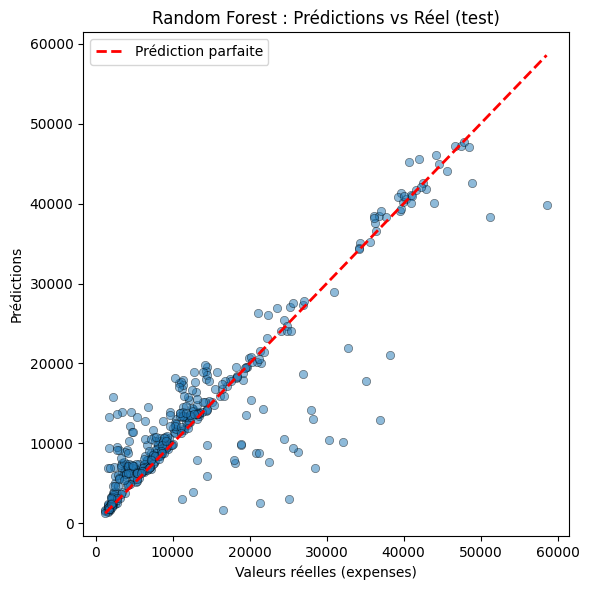

In [ ]:
# 2. Graphique Prédictions vs Réel (données de test)
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_test_rf, alpha=0.5, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Prédiction parfaite')
plt.xlabel('Valeurs réelles (expenses)')
plt.ylabel('Prédictions')
plt.title('Random Forest : Prédictions vs Réel (test)')
plt.legend()
plt.tight_layout()
plt.show()

### Oversampling : non applicable

**Oversampling** (SMOTE, etc.) sert en **classification** quand les classes sont déséquilibrées (ex. 95 % classe A, 5 % classe B). On suréchantillonne la classe minoritaire.

Ici, on prédit **expenses** (valeur continue) : c’est un problème de **régression**. L’oversampling ne s’applique pas. ✓ Pas nécessaire avant déploiement.

In [32]:
import joblib

# Mapping modèle nom -> (objet modèle, scaler si applicable)
modeles_dict = {
    'Régression Linéaire': (model_lr, None),
    'Decision Tree': (model_dt, None),
    'Random Forest': (model_rf, None),
    'SVR': (model_svr, scaler_svr),
    'KNN': (model_knn, scaler_knn)
}

# Sélection du meilleur modèle (R² max)
best_model_name = df_comparison.iloc[0]['Modèle']
best_model, best_scaler = modeles_dict[best_model_name]

# Sauvegarde du modèle
joblib.dump(best_model, 'best_model.joblib')
if best_scaler is not None:
    joblib.dump(best_scaler, 'best_scaler.joblib')
    print(f"Modèle et scaler sauvegardés : {best_model_name}")
else:
    print(f"Modèle sauvegardé : {best_model_name} (fichier: best_model.joblib)")

Modèle sauvegardé : Random Forest (fichier: best_model.joblib)


Conclusion
Le Random Forest régularisé est adapté au déploiement. Si les conditions étaient remplies, il a déjà été sauvegardé dans best_model.joblib et peut être utilisé en production.